
# Kaggle - Titanic Dataset Analysis & Forecast
### y = 'survived'


created by Dominic Hernes, 06.08.2022

In [9]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier, Pool

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
# flags, constants and globals
# global variable
base_folder = Path.cwd()
data_folder = base_folder / "data"

# flags
VERBOSITY = True

# constants
RAND_SEED = 1337
VALID_SIZE = 0.2


In [11]:
# functions
def percentile_check(df: pd.DataFrame, key: str, percentile_high: float = 0.95, percentile_low: float = 0.05) -> None:
    q_high = df[key].quantile(percentile_high)
    q_low = df[key].quantile(percentile_low)
    print(f"Percentile check for the metric column '{key}':")
    print(
        f"{'Number above':<18} {q_high:>3n} ({percentile_high * 100:>6.2f}%-Quantil):{df[df[key] > q_high][key].describe()['count']:>10,}")
    print(
        f"{'Number below':<18} {q_low:>3n} ({percentile_low * 100:>6.2f}%-Quantil):{df[df[key] < q_low][key].describe()['count']:>10,}")

In [12]:
# load data
base_folder = Path.cwd()
data_folder = base_folder / "data"
titan_df = pd.read_csv(data_folder / 'train.csv')



## Part 1: Data cleaning / preparation / exploration
### Quick Overview

In [13]:
# Train df head
titan_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Information about the data**<br><br>
PassengerID - Passenger's identification<br>
Survived - Status survived/missing,dead<br> 
Pclass - Ticket/Passenger class<br>
Name - Name of passenger<br>
Sex - Gender of passenger<br>
Age - Age of passenger<br>
SibSp - Number of siblings or spouse<br>
Parch - Number of parents or child<br>
Ticket - Ticket number<br>
Fare - Ticket price<br> 
Cabin - Cabin number<br> 
Embarked - homeport (C=Cherbourg, Q=Queenstown, S=Southampton)

In [14]:
# df info
titan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [15]:
# df describe
titan_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

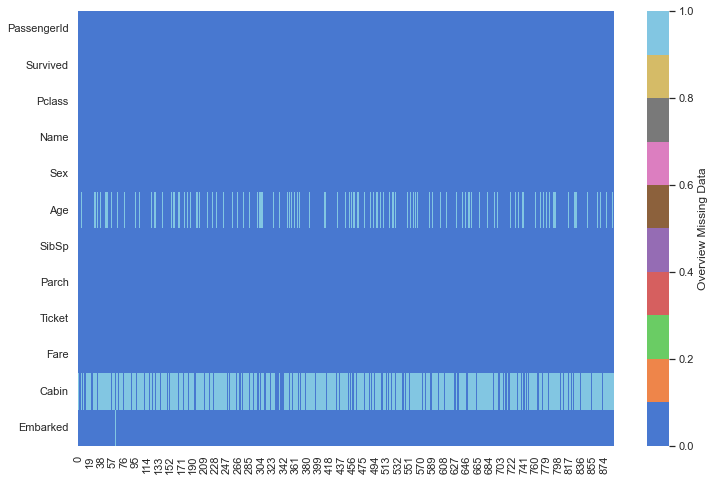

In [16]:
# df missing value heatmap
sns.set(style="darkgrid")
plt.figure(figsize=(12, 8))
sns.heatmap(titan_df.isna().transpose(),
            cmap=sns.color_palette('muted'),
            cbar_kws={'label': 'Overview Missing Data'})

### Data Cleaning and Preparation

#### Data Cleaning - Numerical features
PassengerId/Survived/Pclass are ok!
Age/SibSp/Parch/Fare

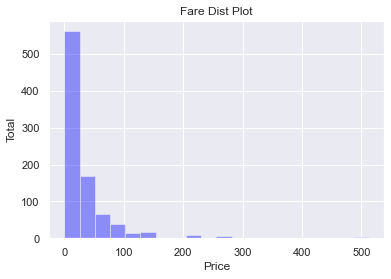

In [17]:
# 'Fare' Feature
# Distplot
sns.distplot(titan_df['Fare'], kde=False, color='blue', bins=20)
plt.title('Fare Dist Plot')
plt.xlabel('Price')
plt.ylabel('Total')
plt.show()

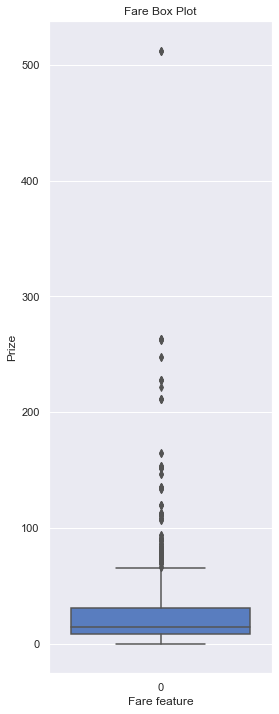

In [18]:
# Box Plot
plt.figure(figsize=(4, 12))
sns.boxplot(data=titan_df['Fare'], palette="muted")
plt.title('Fare Box Plot')
plt.xlabel('Fare feature')
plt.ylabel('Prize')
plt.show()

In [19]:
# percentile check
percentile_check(titan_df, 'Fare', 0.99, 0.01)

Percentile check for the metric column 'Fare':
Number above       249.006 ( 99.00%-Quantil):       9.0
Number below         0 (  1.00%-Quantil):       0.0


In [20]:
# 'Fare' feature outlier
titan_df[titan_df['Fare'] < 4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [21]:
# group by for imputation
agg_fare = titan_df.groupby('Pclass')['Fare'].agg([np.size, np.mean, np.std, np.median, np.min, np.max])

In [22]:
# impute nulls
pcl_idx = agg_fare.index.to_list()
pcl_median = round(agg_fare['median'], 2).to_list()

for i in pcl_idx:
    aggmask = (titan_df['Fare'] == 0) & (titan_df['Pclass'] == i)
    titan_df['Fare'] = titan_df['Fare'].mask(aggmask, pcl_median[i - 1])

In [23]:
# the upper outlier is true and should not be deleted

In [24]:
# 'Age' Feature
titan_df['Age'].isna().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [25]:
# 'Age' group by for imputation
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 90, 100, 150, 200, 250, 300]
agg_age = agg_fare = titan_df.groupby(['Pclass', pd.cut(titan_df['Fare'], bins)])['Age'].agg(
                                      [np.size, np.mean, np.std, np.median, np.min, np.max])

In [26]:
# impute table
agg_age

size       mean        std  median   amin  amax
Pclass Fare                                                        
1      (0, 5]        1.0  33.000000        NaN    33.0  33.00  33.0
       (5, 10]       NaN        NaN        NaN     NaN    NaN   NaN
       (10, 15]      NaN        NaN        NaN     NaN    NaN   NaN
       (15, 20]      NaN        NaN        NaN     NaN    NaN   NaN
       (20, 25]      NaN        NaN        NaN     NaN    NaN   NaN
       (25, 30]     41.0  44.954545  14.155588    45.0  19.00  80.0
       (30, 35]     15.0  48.363636  14.424096    52.0  27.00  71.0
       (35, 40]      8.0  40.000000  14.926487    46.0  16.00  56.0
       (40, 45]      2.0  36.000000        NaN    36.0  36.00  36.0
       (45, 50]      5.0  36.250000  23.300572    26.0  22.00  71.0
       (50, 70]     44.0  36.736842  11.947372    37.0  16.00  65.0
       (70, 90]     43.0  39.650000  14.784868    38.0   4.00  70.0
       (90, 100]     4.0  31.500000  14.387495    27.5  19.00  52.0
       (100, 150]   24.0  33.857143  14.255826    36.0  11.00  58.0
       (150, 200]    9.0  29.102222  18.991420    31.0   0.92  58.0
       (200, 250]   11.0  31.777778  12.060035    29.0  15.00  50.0
       (250, 300]    6.0  28.166667  17.702166    22.0  18.00  64.0
2      (0, 5]        NaN        NaN        NaN     NaN    NaN   NaN
       (5, 10]       NaN        NaN        NaN     NaN    NaN   NaN
       (10, 15]     95.0  32.827558  12.716327    30.0   0.67  70.0
       (15, 20]      9.0  24.978750  19.265755    23.5   0.83  55.0
       (20, 25]     12.0  29.750000  11.608187    30.0   4.00  54.0
       (25, 30]     44.0  28.916591  14.147473    30.0   0.83  54.0
       (30, 35]      6.0  22.900000  12.310565    28.0   6.00  34.0
       (35, 40]      8.0  20.500000  21.520754    13.5   1.00  60.0
       (40, 45]      3.0  16.666667  11.930353    22.0   3.00  25.0
       (45, 50]      NaN        NaN        NaN     NaN    NaN   NaN
       (50, 70]      2.0  36.000000  16.970563    36.0  24.00  48.0
       (70, 90]      5.0  23.200000   5.357238    21.0  18.00  32.0
       (90, 100]     NaN        NaN        NaN     NaN    NaN   NaN
       (100, 150]    NaN        NaN        NaN     NaN    NaN   NaN
       (150, 200]    NaN        NaN        NaN     NaN    NaN   NaN
       (200, 250]    NaN        NaN        NaN     NaN    NaN   NaN
       (250, 300]    NaN        NaN        NaN     NaN    NaN   NaN
3      (0, 5]        1.0  20.000000        NaN    20.0  20.00  20.0
       (5, 10]     323.0  28.029957  10.837375    25.0   0.42  74.0
       (10, 15]     33.0  20.571429  13.535081    19.0   1.00  47.0
       (15, 20]     48.0  21.484848  12.108387    24.0   0.75  44.0
       (20, 25]     30.0  21.150000  13.491810    25.0   1.00  41.0
       (25, 30]     15.0  15.454545  16.890019     8.0   2.00  45.0
       (30, 35]     15.0  17.266667  15.741059     9.0   2.00  48.0
       (35, 40]      6.0  13.500000  14.788509    10.5   1.00  41.0
       (40, 45]      NaN        NaN        NaN     NaN    NaN   NaN
       (45, 50]      6.0  15.666667  14.361987    12.5   1.00  43.0
       (50, 70]     14.0  29.500000   3.000000    30.0  26.00  32.0
       (70, 90]      NaN        NaN        NaN     NaN    NaN   NaN
       (90, 100]     NaN        NaN        NaN     NaN    NaN   NaN
       (100, 150]    NaN        NaN        NaN     NaN    NaN   NaN
       (150, 200]    NaN        NaN        NaN     NaN    NaN   NaN
       (200, 250]    NaN        NaN        NaN     NaN    NaN   NaN
       (250, 300]    NaN        NaN        NaN     NaN    NaN   NaN

In [27]:
# 'Age' imputation
titan_df['Age'] = titan_df['Age'].fillna(0)

In [28]:
for i in range(len(titan_df['Age'])):
    if titan_df.loc[i, 'Age'] == 0:
        titan_df.loc[i, 'Age'] = agg_age.loc[titan_df.loc[i, 'Pclass'], titan_df.loc[i, 'Fare']]['median']

In [29]:
# null value check
titan_df['Age'].isna().value_counts()

False    891
Name: Age, dtype: int64

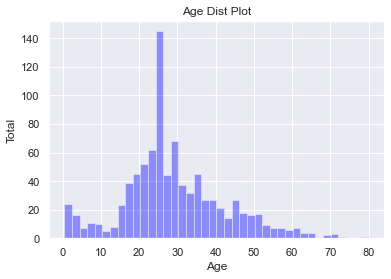

In [30]:
# 'Age' dist plot
sns.distplot(titan_df['Age'], kde=False, color='blue', bins=40)
plt.title('Age Dist Plot')
plt.xlabel('Age')
plt.ylabel('Total')
plt.show()

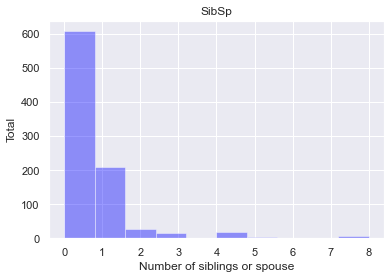

In [31]:
# 'SibSp' & 'Parch' Features
#
# 'SibSp*
sns.distplot(titan_df['SibSp'], kde=False, color='blue', bins=10)
plt.title('SibSp')
plt.xlabel('Number of siblings or spouse')
plt.ylabel('Total')
plt.show()

In [32]:
# percentile check
percentile_check(titan_df, 'SibSp', 0.99, 0.01)

Percentile check for the metric column 'SibSp':
Number above         5 ( 99.00%-Quantil):       7.0
Number below         0 (  1.00%-Quantil):       0.0


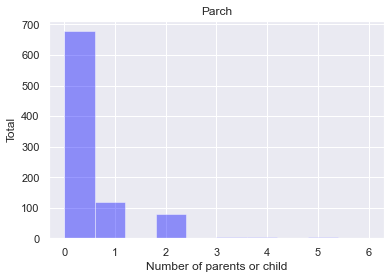

In [33]:
# 'Parch'
sns.distplot(titan_df['Parch'], kde=False, color='blue', bins=10)
plt.title('Parch')
plt.xlabel('Number of parents or child')
plt.ylabel('Total')
plt.show()

In [34]:
# percentile check
percentile_check(titan_df, 'Parch', 0.99, 0.01)

Percentile check for the metric column 'Parch':
Number above         4 ( 99.00%-Quantil):       6.0
Number below         0 (  1.00%-Quantil):       0.0


In [35]:
# creating a 'total_family' feature
titan_df['total_family'] = titan_df['SibSp'] + titan_df['Parch']

#### Data Cleaning - Categorial/Object features

In [36]:
# 'Embarked' Feature
titan_df[titan_df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_family
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


In [37]:
# both passengers have the same ticket id=113572 and are the only ones with this id
titan_df[titan_df['Ticket'] == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_family
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


In [38]:
# searching a match in 'name'
# Icard, Miss., Amelie
# Stone, Mrs. George Nelson (Martha Evelyn)
# https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
# boared = Southampton
titan_df['Embarked'] = titan_df['Embarked'].mask(titan_df['Ticket'] == '113572', 'S')

<AxesSubplot:>

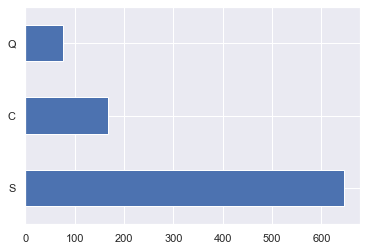

In [39]:
# Bar Plot 'Embarked'
sns.set(style="darkgrid")
titan_df['Embarked'].value_counts().plot(kind='barh')

In [40]:
# 'Sex' Feature
titan_df['Sex'] = titan_df['Sex'].map({'male': 1, 'female': 0})

<AxesSubplot:>

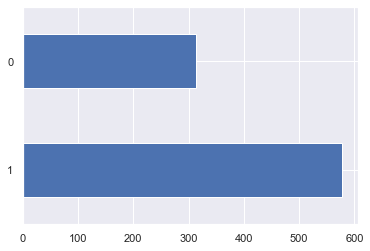

In [41]:
# Bar Plot 'Sex' - Male=1, Female=0
sns.set(style="darkgrid")
titan_df['Sex'].value_counts().plot(kind='barh')

In [42]:
# 'Ticket' Feature
# https://www.encyclopedia-titanica.org/community/threads/ticket-numbering-system.20348/
# I don't think we pull out much value in this feature
# So a simple cleanup on the ticket number is sufficient so the agents are removed from this feature
ticket_split = titan_df["Ticket"].str.rsplit(" ", n=1, expand=True)
ticket_split.columns = 'T0 T1'.split()
ticket_split = ticket_split.fillna(np.nan)
ticket_split['T1'] = ticket_split['T1'].fillna(ticket_split['T0'])
ticket_split['T1'] = ticket_split['T1'].str.replace('LINE', '0').str.strip()
ticket_split['T1'] = ticket_split['T1'].astype(int)
del ticket_split['T0']
ticket_split.columns = ['Ticketnumber']

In [43]:
# concat ticketnummer
titan_df = pd.concat([titan_df, ticket_split], axis=1)
del titan_df['Ticket']

In [44]:
# 'Name' Feature
# will be deleted, as it is no longer useful for the models
# in the Date are better features to use, like sex and passengerID
del titan_df['Name']

In [45]:
# 'Cabin' Feature
# https://www.encyclopedia-titanica.org/titanic-deckplans/
# The cabin values consist of the deck and the room number. Hypothesis: This characteristic 
# should have a high influence on the forecast, like the ticket class and also correlate.
# We should split this feature in number/deck and check nan
titan_df['Cabin'].isna().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

We need to we must impute the missing<br>
https://titanic.fandom.com/wiki/First_Class_Staterooms<br>
First Class - Decks A/B/C<br>
Most of them on B(101)/C(134) - highest on Boatdeck(6) - A(36) lowest on D(49) and F(4)<br>
Sum = 330 First Class rooms<br>
price from £400 to £870<br>
<br>
https://titanic.fandom.com/wiki/Second_Class_Cabins<br>
Second Class - Decks D(39)/E(65)/(F64)<br>
Sum = 168 Rooms<br>
<br><br> 
https://titanic.fandom.com/wiki/Third_Class_cabins<br>
Third Class - Decks D/E/F/G<br>
It is true that the lower the deck the higher the probability of drownin
Imputation is vague because the rate of missing values is high. We use this 
imputation for testing purposes to see if we can increase the accuracy.
After Testing various imputations. I decided to drop this feature 

In [46]:
# save df without 'Cabin' Feature
# dropping the feature for a direct comparison
titan_df_wo_cabin = titan_df.copy()
del titan_df_wo_cabin['Cabin']
del titan_df_wo_cabin['PassengerId']

### Data Visualization & Preparation

In [47]:
# OneHot Encoding to transform the categorial features
oh_enc = OneHotEncoder(handle_unknown='ignore')

In [48]:
# titan_df_wo_cabin - 'Embarked'
transformer_wo_cabin = make_column_transformer(
    (oh_enc, ['Embarked']),
    remainder='passthrough')

transformed_wo_cabin = transformer_wo_cabin.fit_transform(titan_df_wo_cabin)
titan_df_wo_cabin = pd.DataFrame(transformed_wo_cabin, columns=transformer_wo_cabin.get_feature_names())
titan_df_wo_cabin.columns = titan_df_wo_cabin.columns.str.replace('onehotencoder__x0', 'Embarked')

Text(0.5, 1.0, 'titan_df_wo_cabin corr plot')

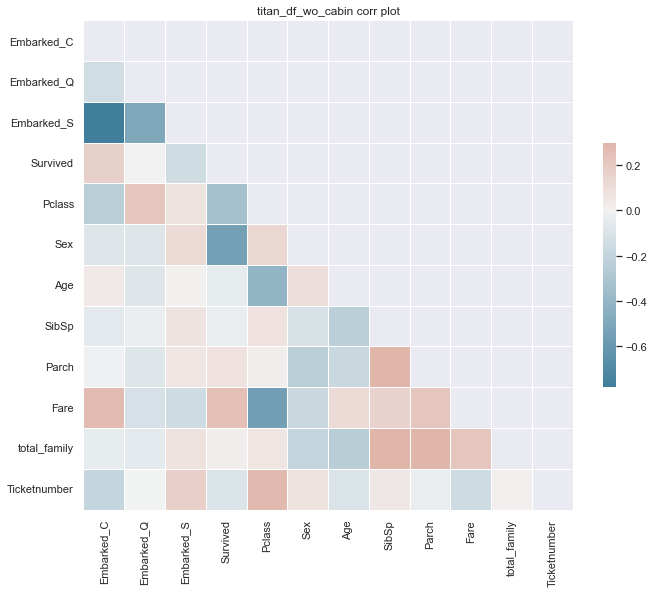

In [49]:
# Correlation Plots
corr = titan_df_wo_cabin.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('titan_df_wo_cabin corr plot')

In [50]:
# z-score / standard scaler
scaled_columns = titan_df_wo_cabin.columns
scaled_columns_clean = list(scaled_columns)
del scaled_columns_clean[3]

titan_wo_survived = titan_df_wo_cabin.copy()
del titan_wo_survived['Survived']

scaled_features = StandardScaler().fit_transform(titan_wo_survived.values)
scaled_features_df = pd.DataFrame(scaled_features, index=titan_df_wo_cabin.index, columns=scaled_columns_clean)
features_df_full = pd.concat([scaled_features_df, titan_df_wo_cabin['Survived'].astype(int)], axis=1)

In [51]:
features_df_full.describe()

,Embarked_C,Embarked_Q,Embarked_S,Pclass,Sex,Age,SibSp,Parch,Fare,total_family,Ticketnumber,Survived
count,8.910000e+02,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000
mean,-1.993666e-17,0.000000,-8.373399e-17,-8.772133e-17,-1.156327e-16,1.156327e-16,4.386066e-17,5.382900e-17,-4.585433e-17,-3.987333e-18,1.993666e-18,0.383838
std,1.000562e+00,1.000562,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.486592
min,-4.820427e-01,-0.307562,-1.623803e+00,-1.566107e+00,-1.355574e+00,-2.149345e+00,-4.745452e-01,-4.736736e-01,-5.780959e-01,-5.609748e-01,-4.526791e-01,0.000000
25%,-4.820427e-01,-0.307562,-1.623803e+00,-3.693648e-01,-1.355574e+00,-5.421266e-01,-4.745452e-01,-4.736736e-01,-4.991834e-01,-5.609748e-01,-4.308636e-01,0.000000
50%,-4.820427e-01,-0.307562,6.158384e-01,8.273772e-01,7.376951e-01,-2.442176e-01,-4.745452e-01,-4.736736e-01,-3.665701e-01,-5.609748e-01,-2.818772e-01,0.000000
75%,-4.820427e-01,-0.307562,6.158384e-01,8.273772e-01,7.376951e-01,5.005547e-01,4.327934e-01,-4.736736e-01,-2.822968e-02,5.915988e-02,7.635297e-02,1.000000
max,2.074505e+00,3.251373,6.158384e-01,8.273772e-01,7.376951e-01,3.777553e+00,6.784163e+00,6.974147e+00,9.674308e+00,5.640372e+00,4.274435e+00,1.000000


## Part 2: Train and evaluate different Models (XGBoost)


#### CatBoost

In [52]:
titan_df_wo_cabin_xgb = features_df_full.copy()
X = titan_df_wo_cabin_xgb
y = X.pop('Survived').values

pool_data = Pool(X, y)

In [53]:
CatBoost = CatBoostClassifier()

param = {
    'iterations': [500],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'l2_leaf_reg': [None, 1, 2],
    'loss_function': ['Logloss'],
    'verbose': [False],
    'random_seed': [RAND_SEED]
}

Grid_CatBoost= GridSearchCV(estimator=CatBoost, param_grid=param, cv=5, n_jobs=-1, verbose=3)
Grid_CatBoost.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

In [ ]:
Grid_CatBoost.best_score_

In [ ]:
Grid_CatBoost.best_params_

In [ ]:
model = CatBoostClassifier(iterations=500,
                           max_depth=8,
                           learning_rate=0.5,
                           l2_leaf_reg=1,
                           loss_function='Logloss',
                           verbose=True,
                           random_seed=RAND_SEED)

model.fit(X, y)

In [ ]:
model.score(pool_data)

## Part 3: Forecasting the Testfile

In [ ]:
# load the testfile
titan_df_valid = pd.read_csv('../input/titanic/test.csv')
passengerid = titan_df_valid.copy()['PassengerId']

### prepare the text.csv for the forcasting

In [ ]:
# creating a 'total_family' feature
titan_df_valid['total_family'] = titan_df_valid['SibSp'] + titan_df_valid['Parch']

In [ ]:
# transform 'Sex' feature
titan_df_valid['Sex'] = titan_df_valid['Sex'].map({'male': 1, 'female': 0})

In [ ]:
# clean up 'ticket' - feature
# 'Ticket' Feature
ticket_split_valid = titan_df_valid["Ticket"].str.rsplit(" ", n=1, expand=True)
ticket_split_valid.columns = 'T0 T1'.split()
ticket_split_valid = ticket_split_valid.fillna(np.nan)
ticket_split_valid['T1'] = ticket_split_valid['T1'].fillna(ticket_split_valid['T0'])
ticket_split_valid['T1'] = ticket_split_valid['T1'].astype(int)
del ticket_split_valid['T0']
ticket_split_valid.columns = ['Ticketnumber']

In [ ]:
# concat ticketnummer
titan_df_valid = pd.concat([titan_df_valid, ticket_split_valid], axis=1)
del titan_df_valid['Ticket']

In [ ]:
# del columns
del titan_df_valid['Cabin']
del titan_df_valid['Name']
del titan_df_valid['PassengerId']

In [ ]:
titan_df_valid['Age'] = titan_df_valid['Age'].fillna(0)
titan_df_valid['Fare'] = titan_df_valid['Fare'].fillna(0)

In [ ]:
# 'Embarked' OneHot Encoding
transformer_df_valid = make_column_transformer(
    (oh_enc, ['Embarked']),
    remainder='passthrough')

transformed_df_valid = transformer_df_valid.fit_transform(titan_df_valid)
titan_df_valid = pd.DataFrame(transformed_df_valid, columns=transformer_df_valid.get_feature_names())
titan_df_valid.columns = titan_df_valid.columns.str.replace('onehotencoder__x0', 'Embarked')

In [ ]:
# scaling
scaled_features = StandardScaler().fit_transform(titan_df_valid.values)
scaled_features_df = pd.DataFrame(scaled_features, index=titan_df_valid.index, columns=titan_df_valid.columns)

In [ ]:
# since RF provided the best results, the forecasts are made on this model
predictions = model.predict(scaled_features_df)

predictions_titanic = pd.DataFrame({'PassengerId': passengerid, 'Survived': predictions})
predictions_titanic = predictions_titanic.astype(int)
predictions_titanic.to_csv('./submission.csv', index=False)
print(predictions_titanic)